#Convolutional Neural Network Implementation for Collision Prediction

Author: Rohit Mishra

Last Update: April 14, 2020.
Created: April 1, 2020.
___
In this notebook, the applicability of CNN models to predict collisions in connected vehicle systems has been tested. 

The data consists of driving parameters such as vehicle speed, position, acceleration, steering angle, etc. It also consists of the warning parameters and the scenario type. 


The ability of CNNs to capture paterns has been implemented to analyze the time series nature of the driving data and make subsequent collision predictions.


In the first part, only the data collected from the driving simulator (excluding the warning parameters and scenario type) has been used to train the CNN.


In the second part, the left out features (warning parameters and scenario type) have been included to train the model.
___

 


In [1]:
# Importing all required packages

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


# For model development

%tensorflow_version 1.x
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten
from keras.layers import Dropout, Input, concatenate,Reshape, Lambda
from keras import optimizers
from tensorflow.keras.backend import squeeze

# For model training

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# Importing the time series input data

filepath_main_data = "/cleaned_data_version_01.xlsx"
driving_data = pd.read_excel(filepath_main_data)
driving_data = driving_data.drop(['padek2','padel2','trans_gear'],axis = 1)

# Importing the collision outcome for the corresponding input data

filepath_output = "/output_data_version_01.xlsx"
output_data = pd.read_excel(filepath_output)
output_data = output_data.drop(['Unnamed: 0'],axis = 1)
output_data = output_data.values

# Importing the data split vector which stores the length of each time series data

filepath_data_split = "/data_split_version_01.xlsx"
data_split_vector = pd.read_excel(filepath_data_split)
data_split_vector = data_split_vector.drop(['Unnamed: 0'],axis = 1)
data_split_vector = data_split_vector.values

# Importing the scenario data which contains the warning and scenario values
# This is followed by some pre-processing

filepath_scenario_data = "/scenario_data_version_01.xlsx"
scenario_vector = pd.read_excel(filepath_scenario_data)
scenario_vector = scenario_vector.drop(['Unnamed: 0'],axis = 1)
scenario_vector = scenario_vector.values
scaler1 = MinMaxScaler(feature_range = (0,1))
scenario_vector = scaler1.fit_transform(scenario_vector)
scenario_vector = scenario_vector.reshape(1024,4,1)


In [0]:
# Feature Engineering - Replacing the subject vehicle position and lead vehicle
# position with their difference

driving_data['separation'] = driving_data['dis(feet)'] - driving_data['lvd']

# Necessary data preprocessing 

driving_data = driving_data.drop(['dis(feet)' , 'lvd','Unnamed: 0'],axis = 1)
driving_data = driving_data.values

In [0]:
# Function to scale the data

def data_scaler(driving_data, data_split_vector):
    
    no_of_data_points = driving_data.shape[0]
    no_of_columns = driving_data.shape[1]

    scaler = MinMaxScaler(feature_range = (0,1))
    scaledData = scaler.fit_transform(driving_data)
    scaledData = scaledData.reshape([1, no_of_data_points, no_of_columns])
    

    return paddingMethod(scaledData, data_split_vector)


In [0]:
# Function post pads the data with zeros 

def paddingMethod(input_data, data_split_vector):
    
    padded_data = np.zeros((len(data_split_vector),max(max(data_split_vector)),input_data.shape[2]))

    j = 0    
    for idx, length in enumerate(data_split_vector):
        for i in range (max(length)):
            padded_data[idx,i,:] = (input_data[0,j+i,:])
        j += max(length)
        
    print("The input data shape is {}".format(padded_data.shape))
    
    
    return padded_data

In [8]:
# Preprocessing the input data using the functions

input_data = data_scaler(driving_data, data_split_vector)

The input data shape is (1024, 88, 11)


Text(0, 0.5, 'Time Series')

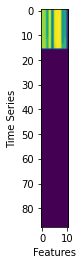

In [10]:
# Reshaping and Plotting a sample data point

input_data = input_data.reshape(1024,88,11,1)
plt.imshow(input_data[122][:,:,0])
plt.xlabel('Features')
plt.ylabel('Time Series')

_______
For this kind of data, we look for patterns in the horizontal slices of the shape (3 X 11). This allows for training of filters that will learn the relation between different features for experiments that result in collisions or otherwise. Next, we pass a kernel of shape (3 X 1), this allows for learning of the pattern along the time axis. The two components of learning together, paint a holistic picture for the CNN model.
______ 

In [0]:
# Custom test train split function

def test_train_split(input_data, scenario_vector, output_data, test_size = 0.3, shuffle = True, cross_val = False,
                     k_fold = 8, test_fold = 1):
  

  if cross_val == True:
    random.seed(100)
    
    # Parameters
    fold_size = int(input_data.shape[0]/k_fold) # Number of data points in each fold
    tf = test_fold # The fold number which needs to be set out for validation
    
    driver_test = input_data[(tf-1)*fold_size:tf*fold_size]
    output_test = output_data[(tf-1)*fold_size:tf*fold_size]
    scenario_test = scenario_vector[(tf-1)*fold_size:tf*fold_size]

    driver_train = np.delete(input_data, slice((tf-1)*fold_size,tf*fold_size), axis = 0)
    output_train = np.delete(output_data, slice((tf-1)*fold_size,tf*fold_size), axis = 0)
    scenario_train = np.delete(scenario_vector, slice((tf-1)*fold_size,tf*fold_size), axis = 0)
    
  else:
    # Identify the index to split the data between test and train
    train_range = int(np.floor(input_data.shape[0]*test_size))

    # Splitting the data

    driver_train = input_data[:train_range]
    output_train = output_data[:train_range]
    scenario_train = scenario_vector[:train_range] 
    driver_test = input_data[train_range:]
    output_test = output_data[train_range:]
    scenario_test = scenario_vector[train_range:] 
  
  # Shuffle the data if shuffle is true

  if shuffle == True:
      shuffler = np.random.permutation(driver_train.shape[0])
      driver_train = driver_train[shuffler]
      output_train = output_train[shuffler]
      scenario_train = scenario_train[shuffler]

  return driver_train,scenario_train, output_train, driver_test, scenario_test, output_test

In [0]:
# Visualizing training and testing accuracy over the epochs

def learning_curves_visualizer(history):
  
  train_acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  test_loss = history.history['val_loss']

  epochs = range(1,len(train_acc)+1)

  # Learning Accuracy

  plt.plot(epochs,train_acc, 'b', label = 'Training accuracy')
  plt.plot(epochs,test_acc, 'orange',label = 'Testing accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title("Model Evaluation")
  plt.legend()

  plt.show()

  # Learning Loss
  
  plt.plot(epochs,train_loss, 'b', label = 'Training loss')
  plt.plot(epochs,test_loss, 'orange',label = 'Testing loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("Model Evaluation")
  plt.legend()

  plt.show()

  return

In [0]:
# Custom function to classify predictions as 

def evaluator(predictions, test_target):   
    test_predictions = []
    
    # CLassify softmax predictions 

    for i in range(predictions.shape[0]):     
        test_output = predictions[i,:]
        if test_output[0] < test_output[1]:
            test_predictions.append(1)
        else :
            test_predictions.append(0)

    # Record true positive, true negative, false positive and false negative 
    # occurences

    tp = 0
    fp = 0
    fn = 0
    tn = 0
    
    # Classify as true or false positive and negative
    
    for i in range(0, predictions.shape[0]):
        if ((test_predictions[i] == test_target[i]) & (test_predictions[i] == 1)):
            tp += 1
        if ((test_predictions[i] == test_target[i]) & (test_predictions[i] == 0)):
            tn += 1
        elif((test_predictions[i] != test_target[i]) & (test_predictions[i] == 1)):
            fp += 1
        elif((test_predictions[i] != test_target[i]) & (test_predictions[i] == 0)):
            fn += 1
    
    accuracy = (tp+tn)*100/(tp+ tn+fp+fn)
    tn_per = tn*100/(tp+ tn+fp+fn)
    tp_per = tp*100/(tp+ tn+fp+fn)
    fp_per = fp*100/(tp+ tn+fp+fn)
    fn_per = fn*100/(tp+ tn+fp+fn)

    return (accuracy,tp_per,tn_per,fp_per,fn_per)

### Part 1: Model Trained Only On Driving Data



In [0]:
def cross_validated_trainer(input_data, scenario_vector, output_data):
  
  results = []

  for i in range(8): # K-fold cross validation
    
    # Model without the warning parameters
    
    nw_collision_classifier = Sequential()

    # CNN part of the model

    nw_collision_classifier .add(Conv2D(512, kernel_size =(3,11), input_shape = (88,11,1)))
    nw_collision_classifier.add(Conv2D(256, kernel_size =(3,1)))
    nw_collision_classifier.add(MaxPool2D(pool_size = (2,1)))
    nw_collision_classifier.add(Dropout(0.2))

    nw_collision_classifier.add(Flatten()) 

    # ANN part of the model
    
    nw_collision_classifier.add(Dense(512,activation = 'relu'))
    nw_collision_classifier.add(Dropout(0.3))
    nw_collision_classifier.add(Dense(2, activation = 'softmax'))
        
    # Optimizer
    adam = optimizers.adam(lr = 0.00001)

    # Compile Model
    nw_collision_classifier.compile(optimizer = adam, 
                                loss = 'sparse_categorical_crossentropy', 
                                metrics = ['accuracy'])

    # Test and train split
    driver_train, scenario_train, output_train, driver_test, scenario_test, output_test =test_train_split(input_data, scenario_vector, 
                                              output_data, test_size = 0.35,
                                              shuffle =True,
                                              cross_val = True,
                                              k_fold = 8,
                                              test_fold = i+1)
    
  
    # Data generator

    inputdata = ImageDataGenerator()
    training_data = inputdata.flow(driver_train, output_train, batch_size = 10)                     
    testing_data = inputdata.flow(driver_test, output_test, batch_size = 10)

    # Keeping track of the validation accuracy and storing the best weights
    checkpointer = ModelCheckpoint(filepath="best_weights_nwclassifier_{}.hdf5".format(i+1), 
                                  monitor = 'val_accuracy',
                                  verbose=0, 
                                  save_best_only=True)
    
    # Training the model
    history = nw_collision_classifier.fit_generator(training_data,
                                      epochs = 300,
                                      callbacks=[checkpointer],
                                      validation_data = testing_data)
    
    # Load best weights
    nw_collision_classifier.load_weights('best_weights_nwclassifier_{}.hdf5'.format(i+1))

    # Classify
    
    predictions = nw_collision_classifier.predict(driver_test)
    result = evaluator(predictions, output_test)
    results.append(result)

    # Learning curve visualizations
    learning_curves_visualizer(history)
  

  return results

In [0]:
results = cross_validated_trainer(input_data, scenario_vector, output_data)

Epoch 1/300
90/90 [==============================] - 1s 13ms/step - loss: 0.6011 - accuracy: 0.7522 - val_loss: 0.5550 - val_accuracy: 0.7266
Epoch 2/300
90/90 [==============================] - 1s 11ms/step - loss: 0.5573 - accuracy: 0.7522 - val_loss: 0.8267 - val_accuracy: 0.7266
Epoch 3/300
90/90 [==============================] - 1s 11ms/step - loss: 0.5465 - accuracy: 0.7522 - val_loss: 0.6660 - val_accuracy: 0.7266
Epoch 4/300
90/90 [==============================] - 1s 11ms/step - loss: 0.5394 - accuracy: 0.7522 - val_loss: 0.8446 - val_accuracy: 0.7266
Epoch 5/300
90/90 [==============================] - 1s 11ms/step - loss: 0.5350 - accuracy: 0.7522 - val_loss: 0.6017 - val_accuracy: 0.7266
Epoch 6/300
90/90 [==============================] - 1s 11ms/step - loss: 0.5312 - accuracy: 0.7545 - val_loss: 0.7583 - val_accuracy: 0.7266
Epoch 7/300
90/90 [==============================] - 1s 11ms/step - loss: 0.5239 - accuracy: 0.7545 - val_loss: 0.7684 - val_accuracy: 0.7266
Epoch 

In [0]:
results

[(82.03125, 12.5, 69.53125, 3.125, 14.84375),
 (68.75, 15.625, 53.125, 5.46875, 25.78125),
 (82.03125, 5.46875, 76.5625, 2.34375, 15.625),
 (83.59375, 6.25, 77.34375, 0.78125, 15.625),
 (82.03125, 9.375, 72.65625, 3.125, 14.84375),
 (78.90625, 11.71875, 67.1875, 5.46875, 15.625),
 (81.25, 6.25, 75.0, 3.90625, 14.84375),
 (85.15625, 2.34375, 82.8125, 0.78125, 14.0625)]

#### Model Evaluation:

Average accuracy - 80.4625%
True Positive - 8.69%
True Negative - 71.78%
False Positive - 3.13%
False Negative - 16.41%

### Part 2: Model Trained with Warning Parameters and Driving Data

In [0]:
def cross_validated_trainer_with_warning(input_data, scenario_vector, output_data):
  
  results = []

  for i in range(8): # Cross-validation
    
    # Model with added warning parameters

    # Two sets of inputs - Driving data and Scenario data

    inputA = Input(shape = (88,11,1))
    inputB = Input(shape = (4,1))

    # CNN part of the model

    output = Conv2D(512, (3,11), activation = 'relu')(inputA)
    output = Conv2D(256, (3,1), activation='relu')(output)
    output = MaxPool2D((2,1))(output)
    output = Flatten()(output)

    # Dense Layer 
    output = Dense(1024, activation = 'relu')(output)

    # Combination of the Driving data and Scenario data

    reshaped_output = Reshape((1024,1))(output)
    output = concatenate([reshaped_output,inputB], axis = 1)
    output = Lambda(lambda x: squeeze(x, 2))(output)

    # Dense layers

    output1 = Dense(512,activation = 'relu')(output)
    output = Dropout(0.2)(output1)
    output = Dense(2, activation='softmax')(output)
    
    # Model
    collision_classifier = Model(inputs = [inputA, inputB], outputs = output)
    
    # Optimizer
    adam = optimizers.adam(lr = 0.00001)
    
    # Model compilation
    collision_classifier.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
   

    # Test and train split
    driver_train, scenario_train, output_train, driver_test, scenario_test, output_test =test_train_split(input_data, scenario_vector, 
                                              output_data, test_size = 0.35,
                                              shuffle =True,
                                              cross_val = True,
                                              k_fold = 8,
                                              test_fold = i+1)
    
  
    # Data generator
    
    inputdata = ImageDataGenerator()
    training_data = inputdata.flow([driver_train,scenario_train], output_train, batch_size = 10)                     
    testing_data = inputdata.flow([driver_test,scenario_test], output_test, batch_size = 10)

    # Keeping track of the validation accuracy and storing the best weights
    checkpointer = ModelCheckpoint(filepath="best_weights_classifier_{}.hdf5".format(i+1), 
                                  monitor = 'val_accuracy',
                                  verbose=0, 
                                  save_best_only=True)
    
    # Training the model
    history = collision_classifier.fit_generator(training_data,
                                      epochs = 300,
                                      callbacks=[checkpointer],
                                      validation_data = testing_data)
    
    # Load best weights
    collision_classifier.load_weights('best_weights_classifier_{}.hdf5'.format(i+1))

    # Classify
    
    predictions = collision_classifier.predict([driver_test,scenario_test])
    result = evaluator(predictions, output_test)
    results.append(result)

    
    #learning_curves_visualizer(history)
  

  return results

In [17]:
results = cross_validated_trainer_with_warning(input_data, scenario_vector, output_data)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/300
90/90 [==============================] - 8s 90ms/step - loss: 0.6171 - accuracy: 0.7444 - val_loss: 0.4376 - val_accuracy: 0.7266
Epoch 2/300
90/90 [==============================] - 2s 18ms/step - loss: 0.5541 - accuracy: 0.7522 - val_loss: 0.5464 - val_accuracy: 0.7266
Epoch 3/300
90/90 [==============================] - 2s 18ms/step - loss: 0.5383 - accuracy: 0.7522 - val_loss: 0.2861 - val_accuracy: 0.7266
Epoch 4/300
90/90 [==============================] - 2s 17ms/step - loss: 0.5288 - accuracy: 0.7522 - val_loss: 0.5806 - val_accuracy: 0.7266
Epoch 5/300
90/90 [==============================] - 2s 17ms/step - loss: 0.5209 - accuracy: 0.7545 - val_loss: 0.8195 - val_accuracy: 0.7266
Epoch 6/300
90/90 [==============================] - 2s 17ms/step - loss: 0.5102 - accuracy: 0.7567 - val_loss: 0.3224 - val_accuracy: 0.7266
Epoch 7/300
90/90 [==============================] - 2s 17ms/step

In [18]:
results

[(79.6875, 10.9375, 68.75, 3.90625, 16.40625),
 (71.875, 20.3125, 51.5625, 7.03125, 21.09375),
 (82.03125, 3.125, 78.90625, 0.0, 17.96875),
 (82.03125, 4.6875, 77.34375, 0.78125, 17.1875),
 (82.8125, 10.15625, 72.65625, 3.125, 14.0625),
 (78.90625, 11.71875, 67.1875, 5.46875, 15.625),
 (82.03125, 3.90625, 78.125, 0.78125, 17.1875),
 (84.375, 3.90625, 80.46875, 3.125, 12.5)]

#### Model Evaluation

Accuracy - 80.47%
True Positive - 8.59%
True Negative - 71.875%
False Positive - 3.03%
False Negative - 16.5%